create new virtualenv with python, current tensorflow
add realecon vars
predict with mse regression using nn and params found in last post
and regression to vars and classify using output 
do correct walkforward xval
xvalidate number of numstocks
gen_predictions like now
calc_returns -> take an argument
gen_returns -> take a function and list of arguments , run all, show returns if verbose
return sharpe, pick best sharpe, print only best if not verbose
xvalidate thresholds for regression
xvalidate thresholds for classification
bring in additional econ vars

Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.


Use classification instead of linear regression 
   - Determine best ex-post portfolio of top 6 (long) - bottom 6 (short) by month.
   - Construct response variable with 3 classes: long, short, flat. 
   - Construct classification models that minimize a cross-entropy objective vs. 3-class response variable

1) Off-the shelf sklearn models

2) Popular boosting models: XGBoost, CatBoost, LiteGBM. These models tend to be faster and more tuneable than the off-the-shelf sklearn classification models and are often used in Kaggle contests

3) Neural net classification model

4) Classification models aren't rank-aware. Misclassifying a true long as flat is penalized the same as misclassifying a true long as short. Improve NN model with a custom loss function to increase the penalty for the worst misclassifications. The hope is that this decreases overall classification accuracy but improve portfolio performance.

5) Instead of top 6 - bottom 6, cross-validate thresholds for .
 
6) NN regression model. Normalize output. Construct portfolio by weighting stocks by regression forecast. Also try weighting by log(1+ normalized forecast).

In [13]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import time 
import copy
import random
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC, LogisticRegression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.testing import all_estimators

# other popular gradient boost algorithms
# XGBoost https://xgboost.readthedocs.io/en/latest/
import xgboost 
# Yandex CatBoost https://catboost.yandex/
import catboost 
# Microsoft LightGbm https://lightgbm.readthedocs.io/en/latest/
import lightgbm as lgb 

from scipy.stats import chisquare, kendalltau

import tensorflow as tf
with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    tf.set_random_seed(1764)
    print(tf.__version__)
    # confirm GPU is in use
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

    sess = tf.Session()
    print (sess.run(c))
    

import keras
from keras.layers.core import Dense, Activation
from keras.layers import Input
from keras.models import Model

from keras.layers.recurrent import LSTM, GRU
from keras.regularizers import l1
from keras.models import Sequential
from keras.models import load_model
from keras import backend as K
K.set_session(sess)
    
#import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# this will make dataframe display as sortable widget
# commented out because sortable tables not viewable using nbviewer
# from beakerx import *

import plotly
# print (plotly.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

random.seed(1764)
np.random.seed(1764)


1.8.0
[[22. 28.]
 [49. 64.]]


In [14]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']

#for ind in industries:
#    data[ind+".3m"] = pd.rolling_mean(data[ind],3)
    
#for ind in industries:
#    data[ind+".6m"] = pd.rolling_mean(data[ind],6)

#for ind in industries:
#    data[ind+".12m"] = pd.rolling_mean(data[ind],12)
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 60)


,Food,Food.lead
yyyymm,,
195912,2.01,-4.49
196001,-4.49,3.35
196002,3.35,-1.67
196003,-1.67,1.17
196004,1.17,8.20
196005,8.20,5.39
196006,5.39,-2.11
196007,-2.11,4.57
196008,4.57,-3.88


In [15]:
# exclude 2017 and later to tie to paper
# data = data.loc[data.index[data.index < 201701]]
data = data.loc[data.index[data.index > 195911]]
data


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
yyyymm,,,,,,,,,,,,,,,,,,,,,
195912,2.01,0.35,-3.02,1.64,7.29,0.67,1.87,-1.97,3.08,0.74,...,0.62,-6.18,-7.93,-9.41,-4.31,-5.33,-6.09,-10.08,-4.68,-3.98
196001,-4.49,-5.71,-2.05,1.21,-5.47,-7.84,-8.53,-6.68,-10.03,-4.77,...,8.07,9.13,5.09,3.00,-0.94,1.42,4.00,1.81,-0.98,6.32
196002,3.35,-2.14,2.27,4.23,2.39,9.31,1.44,-0.02,-0.74,0.32,...,-0.21,-0.31,3.34,-2.43,-4.99,-1.37,-0.13,-3.88,0.05,-2.43
196003,-1.67,-2.94,-0.18,-0.65,2.18,-0.56,-2.59,1.26,-2.75,-6.79,...,-1.24,7.14,1.77,0.41,-2.13,0.45,-0.53,8.86,-0.64,0.55
196004,1.17,-2.16,1.35,6.46,-1.17,-1.27,0.21,1.49,-5.53,-1.10,...,3.05,-1.75,11.90,2.85,0.90,1.65,3.11,0.80,-0.45,1.02
196005,8.20,-0.52,2.44,7.28,11.67,7.74,1.74,13.50,3.40,2.10,...,-0.58,-8.07,2.39,3.50,2.17,5.96,3.41,1.03,3.72,6.41
196006,5.39,0.47,4.73,2.24,0.02,6.38,-1.59,-0.40,0.45,4.04,...,-0.03,2.84,-2.02,-4.10,-3.11,-6.16,-2.99,-1.25,0.09,-5.95
196007,-2.11,-0.79,4.60,-4.72,0.23,-0.60,-1.10,-3.99,-6.80,-3.14,...,6.94,5.69,2.71,1.18,1.98,4.51,2.85,2.05,3.47,3.48
196008,4.57,3.24,5.20,7.16,3.63,5.09,3.34,2.29,1.17,-0.84,...,-6.07,-3.53,-7.61,-7.37,-7.07,-8.44,-8.57,-1.90,-5.78,-4.21


In [16]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
count,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,...,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000
mean,0.688666,0.727030,0.985079,0.732095,0.532253,0.564333,0.690387,0.665825,0.552367,0.687145,...,0.515968,0.729928,0.622970,0.534806,0.601090,0.631076,0.698235,0.728766,0.637547,0.396628
std,4.308660,5.058992,6.032324,7.128170,5.780362,4.728000,6.355251,4.897557,5.482363,6.970961,...,4.607931,6.486956,6.698787,5.021876,5.707154,5.571040,5.334178,6.065564,5.381389,5.771655
min,-18.150000,-20.190000,-25.320000,-33.400000,-26.560000,-22.240000,-31.500000,-21.060000,-28.600000,-33.110000,...,-16.440000,-28.670000,-32.070000,-27.740000,-28.500000,-29.250000,-29.740000,-31.890000,-22.530000,-28.090000
25%,-1.630000,-2.080000,-2.740000,-3.390000,-2.600000,-2.030000,-2.800000,-2.230000,-2.750000,-3.170000,...,-2.110000,-3.050000,-3.220000,-2.400000,-2.780000,-2.560000,-2.380000,-2.840000,-2.400000,-2.930000
50%,0.740000,0.750000,1.270000,0.940000,0.510000,0.750000,0.700000,0.760000,0.720000,0.640000,...,0.590000,1.010000,0.670000,0.710000,0.900000,0.940000,0.540000,1.080000,0.870000,0.540000
75%,3.070000,3.690000,4.660000,5.260000,3.640000,3.540000,4.310000,3.550000,3.760000,4.480000,...,3.360000,4.260000,4.630000,3.460000,4.040000,3.880000,3.980000,4.300000,4.000000,4.200000
max,19.890000,25.510000,32.380000,34.520000,33.130000,18.220000,31.790000,29.010000,21.680000,59.030000,...,21.220000,23.380000,24.660000,21.000000,18.500000,17.530000,26.490000,27.380000,20.590000,19.960000


In [17]:
X = data.values[:,:npredictors]
Y = data.values[:,-nresponses:]
nrows = X.shape[0]
X.shape

(697, 30)

In [18]:
def subset_selection(X, Y, model_aic, verbose=False, responses=responses, predictors=predictors):
    
    nrows, npreds = X.shape
    nows, nresps = Y.shape
    coef_dict = []
    
    for response_index in range(nresps):
        y = Y[:,response_index]
        model_aic.fit(X, y)
        predcols = [i for i in range(npreds) if model_aic.coef_[i] !=0]

        #y_response = model_aic.predict(X)
        # print ("In-sample LASSO R-squared: %.6f" % r2_score(y, y_response))
        if verbose and responses:
            print("LASSO variables selected for %s: " % responses[response_index])
            print([predictors[i] for i in predcols])
        
        if not predcols:
            if verbose and responses:
                print("No coefs selected for " + responses[response_index] + ", using all")
                print("---")
            predcols = list(range(npreds))    
            
        # fit OLS vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        coef_dict.append(predcols)
        if verbose and responses and predictors:
            print("Running OLS for " + responses[response_index] + " against " + str([predictors[i] for i in predcols]))
            # col nums of selected responses
            model_ols = LinearRegression()
            model_ols.fit(X[:, predcols], y)
            y_pred = model_ols.predict(X[:, predcols])
            print ("In-sample OLS R-squared: %.2f%%" % (100 * r2_score(y, y_pred)))
            print("---")
            
    return coef_dict

#coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'))
coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'), verbose=True, responses=responses, predictors=predictors)
print(coef_dict)
# These subsets line up closely with Table 2
# except Clths, Whlsl, we get different responses

LASSO variables selected for Food.lead: 
['Clths', 'Coal', 'Util', 'Rtail']
Running OLS for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample OLS R-squared: 2.22%
---
LASSO variables selected for Beer.lead: 
['Food', 'Clths', 'Coal']
Running OLS for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample OLS R-squared: 2.55%
---
LASSO variables selected for Smoke.lead: 
['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Running OLS for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample OLS R-squared: 6.47%
---
LASSO variables selected for Games.lead: 
['Books', 'Clths', 'Coal', 'Fin']
Running OLS for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample OLS R-squared: 5.00%
---
LASSO variables selected for Books.lead: 
['Games', 'Books', 'Clths', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Meals', 'Fin']
Running OLS for Books.lead against ['Games

In [19]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[ -3.34  -1.95  -7.59  -7.76 -12.05  -7.5   -5.69  -7.71  -7.37  -5.26
  -9.84  -6.31  -7.15  -6.89  -9.35 -12.49  -2.34  -0.77 -12.16  -4.83
  -3.16 -11.17  -9.73  -8.89  -8.17  -8.28  -6.31 -13.12  -9.78  -6.2 ]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq    -6.89
Autos    -9.35
Carry   -12.49
Mines    -2.34
Coal     -0.77
Oil     -12.16
Util     -4.83
Telcm    -3.16
Servs   -11.17
BusEq    -9.73
Paper    -8.89
Trans    -8.17
Whlsl    -8.28
Rtail    -6.31
Meals   -13.12
Fin      -9.78
Other    -6.20
Name: 197001, dtype: float64


In [20]:
class PredictWrapper():
    """Wrap an sklearn model e.g. LinearRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it"""

    def __init__(self, create_model, coef_dict, fit_missing=None):
        self.create_model = create_model        
        self.coef_dict = coef_dict
        self.fit_missing = fit_missing
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            if self.coef_dict[responsecol]:
                # column indexes to fit against each other
                predcols = self.coef_dict[responsecol]
            else: # no columns selected
                if not self.fit_missing:
                    # default: don't fit if no predictors selected
                    self.models.append(None)
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "mean":
                    # append a numeric value to use
                    self.models.append(np.mean(Y_fit[:,responsecol]))
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "all":
                    # predcols = all columns
                    predcols = range(X_fit.shape[1])

            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit[:, predcols], Y_fit[:,responsecol])
            if verbose:
                print("fit on " + str(X_fit[:, predcols].shape) + str(predcols))
                print(model.coef_)
                            
            self.models.append(model)
                
            #debug
            #print(responsecol)
            #print(X_fit[:, predcols])
            #print("=====")
            #print(Y_fit[:,responsecol])
            #print("=====")
            #print(self.model.coef_)
            #print(self.model.intercept_)
            #print("=====")                

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            #print (type(self.models[responsecol]))
            if type(self.models[responsecol]) == np.float64:
                pred = np.array([self.models[responsecol]] * nrows).reshape(nrows,1)
                predictions.append(pred)
                sys.stdout.write('\010#')
            elif not self.models[responsecol]: 
                # don't predict
                predictions.append(np.array([np.nan] * nrows ).reshape(nrows,1))
                sys.stdout.write('\010N')
            else:
                predcols = self.coef_dict[responsecol]
                y_pred = self.models[responsecol].predict(X_predict[:,predcols])
                if verbose:
                    print("predict on" + str(X_predict[:, predcols].shape) + str(predcols))
                    print(y_pred)
                predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
        

In [21]:
class ClassifyWrapper():
    """Wrap an sklearn model e.g. LogisticRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, create_model):
        self.create_model = create_model        
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit, Y_fit[:,responsecol])
            self.models.append(model)

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            #print(y_pred.shape)
            predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict_proba(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows,1)))
        return [np.hstack(predictions) for predictions in retlist]
        
        

### BacktestModel class to abstract walk-forward validation and backtesting workflow from modeling, portfolio construction, reporting

In [22]:
# typical pipeline
# backtestmodel = BacktestModel(X, # predictors
#                              Y, # responses
#                              create_model=LinearRegression, # create_model which returns a model (needed for 'timestep' which creates different model each timestep)
#                              # or model = someKerasModel, # initialized model that supports fit(X,Y), predict(X) , predicts an entire row,
#                              coef_dict_param=coef_dict_paper, # how to map predictors to responses ("all", "timestep", or a list of lists)
#                              startindex=FIRST_TRAIN_MONTHS, # initial training for backtest
#                              fit_missing='mean', # what to do when no predictors are selected in coef_dict_param - use all predictors, use historical mean, use np.nan
#                              scaler = None) # scaling function like MinMaxScaler

# backtestmodel.gen_predictions(verbose=False) # starting from startindex, step through X,Y month by month, fit up to current month, predict next month, store prediction in self.P
# backtestmodel.walkforward_xval(n_splits=5, verbose=True) # calls gen_predictions with a large step, fits and predicts one large fold at a time (useful to cross-validate quickly)
# backtestmodel.evaluate_predictions() # report metrics on prediction : MSE etc. #TODO: support custom calcs before/after/instead of default calcs
# backtestmodel.gen_returns(calc_returns, verbose=True) # takes a function that returns portfolio returns based on self.P, stores in self.R
# backtestmodel.report_returns(start_date=start_date_str, freq='M') # calc cumulative perf and report (TODO: allow it to take a reporting function to run before/after/in place of default report)
# backtestmodel.evaluate_quantiles(chart=True, verbose=True) # report quantile metrics # TODO: make this a custom calc passed into evaluate_predictions

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 make_classes=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            # by rows
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # self.Xscale = scaler().fit_transform(self.Xscale.transpose()).transpose()
            # self.Yscale = scaler().fit_transform(self.Yscale.transpose()).transpose()
            # by cols
            # MinMaxScaler: each col (min->0, max->1) 
            # StandardScaler: each col (mean->0, SD->1)            
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.Yscale = scaler().fit_transform(self.Yscale)
        
        if make_classes: # doing classification, turn Y target into classes
            self.Yscale = make_classes(self.Yscale)
            self.nclasses = np.unique(self.Yscale).shape[0]
        self.make_classes = make_classes

        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict_regression(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.Ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    def fit_predict_classify(self, ntrain, npredict=1, predict_classes=False, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)

        if self.create_model:
            self.model = ClassifyWrapper(self.create_model)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        Y_predict =  self.model.predict_proba(X_predict, verbose=verbose)
        if predict_classes:
            return np.argmax(np.array(Y_predict), axis=0, out=None)
        else:
            return Y_predict


    def gen_predictions_regression(self,
                                   step=1, 
                                   splits=None,
                                   verbose=False):

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.Ycols = self.Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict_classify(month_index, forecast_rows, predict_classes=True, verbose=False)

            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        
    def gen_predictions_classify(self,
                                 step=1, 
                                 splits=None,
                                 verbose=False,
                                 classindexes=None
                                ):
        # make this generic  - return fit_predict
        # P = average of classindexes weighted by class probability
        self.P = np.zeros_like(self.Yscale)
        if not classindexes:
            classindexes = range(self.nclasses)
            # sum to 1
            divisor = float(sum(classindexes))
            classindexes = [cw / divisor for cw in classindexes]

        progress_i = 0
        self.nrows, self.Ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
                
            classprobs = self.fit_predict_classify(month_index, forecast_rows, verbose=False)
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                for i in range(len(classprobs)):
                    self.P[first_pred_row + row_index, :] += classprobs[i][row_index, :] * classindexes[i]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        
    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):
        if self.make_classes: # classification problem
            if verbose:
                print("classify")
            self.gen_predictions_classify(step=step, splits=splits, verbose=verbose)
        else:
            if verbose:
                print("regression")
            self.gen_predictions_regression(step=step, splits=splits, verbose=verbose)
    
    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        self.mse = np.mean(msetemp)
        print("OOS MSE across all predictions: %.4f" % self.mse)
        self.model.fit(self.Xscale, self.Yscale)
        Y_pred = self.model.predict(self.Xscale)
        self.in_sample_mse = np.mean((Y_pred - self.Yscale) ** 2)
        print("In-sample MSE: %.4f" % self.in_sample_mse)

        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- self.mse/y_variance))
        
        return(self.mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        self.kendalltaus = []
        self.ktpvals = []
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))
            kt, p_val = kendalltau(self.P[row], self.Y[row])
            self.kendalltaus.append(kt)
            self.ktpvals.append(p_val)

        self.kendalltau = np.mean(self.kendalltaus)
        self.kendalltau_pvalue = np.mean(self.ktpvals)         
        print("Avg rank correlation (Kendall's tau): %.4f (Expected: 0)" % (self.kendalltau))
        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols)
        self.quintile_accuracy = accuracy_score(pred_quantiles, true_quantiles)
        print("5-quintile accuracy: %.4f (Expected: 0.2)" % (self.quintile_accuracy))
        
        pred_direction = np.zeros(nrows*ncols)
        true_direction = np.zeros(nrows*ncols)
        for i in range(nrows*ncols):
            if pred_quantiles[i] == 4:
                pred_direction[i] = 1
            elif pred_quantiles[i] == 0:
                pred_direction[i] = -1
            if true_quantiles[i] == 4:
                true_direction[i] = 1
            elif true_quantiles[i] == 0:
                true_direction[i] = -1
        self.directional_accuracy = accuracy_score(pred_direction, true_direction)
        print("Long/short/flat accuracy: %.4f (Expected: 0.44)" % (self.directional_accuracy))

        nrows = nrows * ncols
            
        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])*nrows

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat5 = confusion_matrix(temp_pred, temp_actual)
            diff_mat = conf_mat5 - conf_mat_expected
            if verbose:
                print("Confusion matrix for quantile %d" % q)
                print(conf_mat5)
                cstmp, cspvtmp = chisquare(conf_mat5.reshape(4), conf_mat_expected.reshape(4))
                print("Chi-square: %.4f (p-value: %.8f)" % (cstmp, cspvtmp))

            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = diff_mat[1][1]
            myscores.append(myscore)

        # sum of true positive for top and bottom quintiles
        self.excess_tp = myscores[0] + myscores[4]
        print("Excess true positive in quintiles 1 + 5: %f" % (self.excess_tp))

        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual Quintile')
            plt.xlabel('Predicted Quintile')
            plt.show()

        self.model.fit(self.Xscale, self.Yscale, verbose=verbose)
        Y_pred = self.model.predict(self.Xscale, verbose=verbose)
        nrows, ncols = Y_pred.shape
        self.insample_accuracy=accuracy_score(self.Yscale.reshape(nrows*ncols,1), Y_pred.reshape(nrows*ncols,1))
            
        return None

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-fold indexes
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        self.gen_predictions(splits=last_indexes, verbose=verbose)

    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.Ycols
        longcount = [0] * self.Ycols
        shortcount = [0] * self.Ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
        if verbose:
            for i in range(len(responses)):
                print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                             longcount[i], 
                                                                             shortcount[i], 
                                                                             indcount[i]))
        return self.R

    
    def report_returns(self, start_date='01/01/1970', freq='M', verbose=True):

        first_pred_month=self.startindex        
        self.results = self.R[first_pred_month:]
        nmonths = self.results.shape[0]
        nyears = nmonths/12.0
        index = pd.date_range(start_date,periods=nmonths, freq=freq)
        perfdata = pd.DataFrame(self.results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + self.results / 100)
        self.cumulative_return = perfdata['Equity']
        self.mean_monthly_return_annualized = np.mean(1 + self.results/100) ** 12 - 1
        self.mean_return = (self.cumulative_return[-1]/100) ** (1.0/nyears) - 1
        self.annualized_vol = np.std(self.results/100) * np.sqrt(12.0)
        self.sharpe = self.mean_monthly_return_annualized/self.annualized_vol
        if verbose:
            print("Mean return: %.3f%%" % (self.mean_return * 100 ))
            #print("Mean monthly annualized return: %.3f%%" % (self.mean_monthly_return_annualized * 100 ))
            #print("Monthly annualized volatility: %.3f%%" % (self.annualized_vol * 100))
            print("Monthly Sharpe ratio: %.3f" % (self.sharpe))

    def sharpe_cv(self, port_returns_func_gen, cv_arg_list, verbose=False):
        if verbose:
            print(cv_arg_list)
        best_sharpe=0
        for arg_list in cv_arg_list:
            ret_func = port_returns_func_gen(arg_list)
            self.gen_returns(ret_func, verbose=verbose)
            if verbose:
                print(arg_list)
            self.report_returns(verbose=verbose)
            if self.sharpe > best_sharpe:
                best_cv_params=arg_list
                best_sharpe = self.sharpe
        return best_sharpe, best_cv_params
    
        


In [23]:
# return calculation passed to gen_returns

NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns_gen(numstocks=NUMSTOCKS):
    def calc_returns(prediction_row, return_row, numstocks=numstocks, verbose=False):
        
        # ensure nan sorts to top for shorts
        short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
        # pick bottom numstocks
        select_array = np.argsort(short_sort_array)
        short_indexes = select_array[:numstocks]

        # ensure nan sorts to bottom for longs
        long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
        # pick top numstocks
        select_array = np.argsort(long_sort_array)
        long_indexes = select_array[-numstocks:]

        if verbose:
            print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
            print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

        # compute equal weighted long/short return
        return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes

    return calc_returns

calc_returns = calc_returns_gen(NUMSTOCKS)

In [24]:
def make_n_classes(n=4, class_array=None):
    # return a function to make n classes from Y based on n quantiles (or explicit index boundaries)
    
    def make_classes(Y, nclasses=n, class_array=class_array, verbose=False):
    
        # initialize class array to 0s
        Y_class=np.zeros_like(Y)
        # sort indexes
        Y_sortindex = np.argsort(Y)
        
        if class_array is None: # quantile boundaries
            class_array=[]
            for i in range(n):
                class_array.append(int(np.round(i / nclasses * Y_class.shape[1])))
            class_array.append(Y_class.shape[1])
            
        if verbose:
            print(class_array)
            print("Y")
            print(Y[0])
            # sorted position
            print("Y_sortindex")
            print(Y_sortindex[0]) 
            # sorted array
            print("Sorted")
            print(Y[0,Y_sortindex[0]])
            
        for row in range(Y_class.shape[0]):
            # assign indexes within specified sort range to quantile
            for i in range(nclasses):
                start_index, end_index = class_array[i], class_array[i+1]
                qlist = Y_sortindex[row,start_index:end_index]
                Y_class[row, qlist] = i
            
        if verbose:
            print("Y_class")
            print(Y_class[0])
            print("3s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==3])
            print("2s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==2])
            print("1s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==1])
            print("0s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==0])
            print(Y_class.shape)
            
        return Y_class
    return make_classes

make_four_classes = make_n_classes(4)
make_four_classes(Y, verbose=True)

[0, 8, 15, 22, 30]
Y
[ -4.49  -5.71  -2.05   1.21  -5.47  -7.84  -8.53  -6.68 -10.03  -4.77
  -6.67  -9.38  -4.42 -12.3  -11.71  -5.03  -3.81  -7.91  -7.82  -2.4
   0.62  -6.18  -7.93  -9.41  -4.31  -5.33  -6.09 -10.08  -4.68  -3.98]
Y_sortindex
[13 14 27  8 23 11  6 22 17  5 18  7 10 21 26  1  4 25 15  9 28  0 12 24
 29 16 19  2 20  3]
Sorted
[-12.3  -11.71 -10.08 -10.03  -9.41  -9.38  -8.53  -7.93  -7.91  -7.84
  -7.82  -6.68  -6.67  -6.18  -6.09  -5.71  -5.47  -5.33  -5.03  -4.77
  -4.68  -4.49  -4.42  -4.31  -3.98  -3.81  -2.4   -2.05   0.62   1.21]
Y_class
[2. 2. 3. 3. 2. 1. 0. 1. 0. 2. 1. 0. 3. 0. 0. 2. 3. 1. 1. 3. 3. 1. 0. 0.
 3. 2. 1. 0. 2. 3.]
3s
['-2.05', '1.21', '-4.42', '-3.81', '-2.40', '0.62', '-4.31', '-3.98']
2s
['-4.49', '-5.71', '-5.47', '-4.77', '-5.03', '-5.33', '-4.68']
1s
['-7.84', '-6.68', '-6.67', '-7.91', '-7.82', '-6.18', '-6.09']
0s
['-8.53', '-10.03', '-9.38', '-12.30', '-11.71', '-7.93', '-9.41', '-10.08']
(697, 30)


array([[2., 2., 3., ..., 0., 2., 3.],
       [2., 0., 2., ..., 1., 0., 3.],
       [1., 1., 3., ..., 0., 3., 1.],
       ...,
       [2., 2., 0., ..., 3., 2., 0.],
       [0., 3., 3., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 3., 3.]])

In [25]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [26]:
# test fit_predict
# suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

backtestmodel = BacktestModel(X, Y, create_model=LogisticRegression, 
                              coef_dict_param=coef_dict, 
                              startindex=FIRST_TRAIN_MONTHS, 
                              make_classes=make_four_classes)
print(backtestmodel.Yscale[122:127])
z = backtestmodel.fit_predict_classify(121, npredict=5, verbose=False)
print(len(z))
print(z)
#preds
# 1st row
#2 3 3 0
# 1st col
#2 2 0 2

[[2. 2. 3. 0. 0. 2. 1. 0. 3. 3. 1. 2. 3. 3. 3. 1. 1. 0. 2. 3. 3. 0. 1. 1.
  0. 0. 2. 0. 2. 1.]
 [2. 2. 3. 0. 0. 3. 0. 2. 3. 3. 1. 2. 1. 3. 3. 0. 1. 0. 2. 3. 3. 0. 1. 2.
  1. 0. 2. 0. 1. 1.]
 [2. 2. 3. 0. 0. 2. 0. 2. 3. 0. 1. 1. 1. 2. 3. 1. 3. 3. 3. 3. 3. 0. 1. 1.
  2. 0. 1. 0. 2. 0.]
 [3. 2. 3. 0. 0. 1. 1. 3. 3. 3. 1. 1. 2. 3. 2. 0. 3. 2. 3. 2. 0. 0. 0. 1.
  0. 1. 2. 1. 2. 0.]
 [1. 1. 0. 2. 3. 1. 2. 0. 2. 3. 3. 0. 0. 1. 2. 0. 0. 1. 3. 2. 3. 1. 0. 2.
  2. 1. 3. 0. 3. 3.]]
4
[array([[0.067, 0.191, 0.102, 0.976, 0.136, 0.014, 0.618, 0.001, 0.021,
        0.075, 0.008, 0.761, 0.155, 0.017, 0.46 , 0.167, 0.335, 0.017,
        0.051, 0.002, 0.105, 0.012, 0.476, 0.227, 0.305, 0.399, 0.285,
        0.555, 0.335, 0.608],
       [0.01 , 0.01 , 0.343, 0.205, 0.074, 0.92 , 0.018, 0.215, 0.073,
        0.028, 0.128, 0.426, 0.   , 0.054, 0.011, 0.586, 0.186, 0.34 ,
        0.046, 0.677, 0.667, 0.471, 0.504, 0.15 , 0.037, 0.251, 0.008,
        0.799, 0.037, 0.02 ],
       [0.489, 0.296, 0.495, 0.196,

In [27]:
# check 4-class output probabilities sum to 1
z = backtestmodel.fit_predict_classify(121, npredict=5, verbose=False)
z[0] + z[1] +z[2] + z[3]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [28]:
np.array(z).shape
np.argmax(np.array(z), axis=0, out=None)

array([[2, 3, 3, 0, 1, 3, 0, 2, 1, 3, 2, 0, 2, 3, 3, 2, 1, 1, 3, 3, 3, 3,
        0, 1, 2, 0, 3, 0, 0, 0],
       [2, 3, 3, 1, 1, 0, 2, 2, 2, 3, 3, 0, 2, 1, 1, 0, 3, 1, 3, 0, 0, 0,
        0, 2, 2, 3, 1, 0, 3, 1],
       [0, 2, 0, 3, 3, 3, 2, 1, 3, 3, 1, 0, 0, 2, 3, 2, 0, 0, 1, 0, 1, 0,
        3, 1, 0, 2, 3, 2, 1, 3],
       [2, 1, 0, 0, 0, 3, 0, 3, 1, 1, 0, 3, 2, 1, 3, 0, 0, 0, 1, 3, 2, 1,
        3, 3, 0, 0, 3, 2, 1, 0],
       [2, 2, 0, 0, 1, 2, 0, 2, 1, 0, 1, 3, 2, 3, 1, 1, 0, 3, 1, 3, 3, 1,
        2, 3, 3, 1, 2, 0, 3, 0]])

In [29]:
print(backtestmodel.Yscale[121:126])
backtestmodel.fit_predict_classify(121, npredict=5, predict_classes=True, verbose=False)
#preds
# 1st row
#2 3 3 0
# 1st col
#2 2 0 2

[[1. 2. 0. 2. 0. 0. 0. 1. 0. 1. 3. 3. 2. 3. 2. 1. 2. 3. 1. 3. 3. 0. 0. 1.
  3. 0. 2. 2. 3. 1.]
 [2. 2. 3. 0. 0. 2. 1. 0. 3. 3. 1. 2. 3. 3. 3. 1. 1. 0. 2. 3. 3. 0. 1. 1.
  0. 0. 2. 0. 2. 1.]
 [2. 2. 3. 0. 0. 3. 0. 2. 3. 3. 1. 2. 1. 3. 3. 0. 1. 0. 2. 3. 3. 0. 1. 2.
  1. 0. 2. 0. 1. 1.]
 [2. 2. 3. 0. 0. 2. 0. 2. 3. 0. 1. 1. 1. 2. 3. 1. 3. 3. 3. 3. 3. 0. 1. 1.
  2. 0. 1. 0. 2. 0.]
 [3. 2. 3. 0. 0. 1. 1. 3. 3. 3. 1. 1. 2. 3. 2. 0. 3. 2. 3. 2. 0. 0. 0. 1.
  0. 1. 2. 1. 2. 0.]]


array([[2, 3, 3, 0, 1, 3, 0, 2, 1, 3, 2, 0, 2, 3, 3, 2, 1, 1, 3, 3, 3, 3,
        0, 1, 2, 0, 3, 0, 0, 0],
       [2, 3, 3, 1, 1, 0, 2, 2, 2, 3, 3, 0, 2, 1, 1, 0, 3, 1, 3, 0, 0, 0,
        0, 2, 2, 3, 1, 0, 3, 1],
       [0, 2, 0, 3, 3, 3, 2, 1, 3, 3, 1, 0, 0, 2, 3, 2, 0, 0, 1, 0, 1, 0,
        3, 1, 0, 2, 3, 2, 1, 3],
       [2, 1, 0, 0, 0, 3, 0, 3, 1, 1, 0, 3, 2, 1, 3, 0, 0, 0, 1, 3, 2, 1,
        3, 3, 0, 0, 3, 2, 1, 0],
       [2, 2, 0, 0, 1, 2, 0, 2, 1, 0, 1, 3, 2, 3, 1, 1, 0, 3, 1, 3, 3, 1,
        2, 3, 3, 1, 2, 0, 3, 0]])

11:18:27 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  9
Food: long 201 times, short 109 times, total 310 times
Beer: long 176 times, short 143 times, total 319 times
Smoke: long 217 times, short 151 times, total 368 times
Games: long 170 times, short 189 times, total 359 times
Books: long 204 times, short 121 times, total 325 times
Hshld: long 201 times, short 157 times, total 358 times
Clths: long 208 times, short 165 times, total 373 times
Hlth: long 200 times, short 155 times, total 355 times
Chems: long 105 times, short 209 times, total 314 times
Txtls: long 203 times, short 154 times, total 357 times
Cns

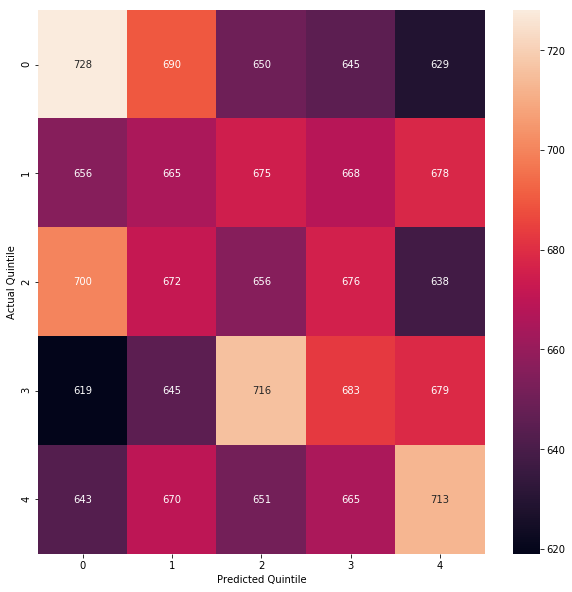

In [30]:
# test model on our calculated coef_dict
# bad methodology, introduces snooping
# selects LASSO vars over whole timespan
# uses selected vars to do OLS backtest
# included as an example of what not to do


### OUTPUT xval sharpe for each fold w/ diff quantiles
# ideally average sharpe by quantile size

backtestmodel = BacktestModel(X, Y, 
                              create_model=LogisticRegression, 
                              coef_dict_param=coef_dict, 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
_, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16))
print("best return gen params: ", best_params)
backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
#backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)

In [31]:
backtestmodel.P

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.212, 0.186, 0.161, ..., 0.256, 0.24 , 0.272],
       [0.224, 0.199, 0.272, ..., 0.269, 0.238, 0.171],
       [0.297, 0.346, 0.32 , ..., 0.25 , 0.217, 0.271]])

In [44]:
# enumerate classifiers 
estimators = []

for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)

estimators

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble.bagging.BaggingClassifier'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process.gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
<class 'sklearn.semi_supervised.label_propagation.LabelPropagation'>
<class 'sklearn.semi_supervised.label_propagation.LabelSpreading'>
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
<class 'sklearn.linear_model.logistic.LogisticRegression'>
<class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
<c

[sklearn.ensemble.weight_boosting.AdaBoostClassifier,
 sklearn.ensemble.bagging.BaggingClassifier,
 sklearn.naive_bayes.BernoulliNB,
 sklearn.calibration.CalibratedClassifierCV,
 sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.tree.tree.ExtraTreeClassifier,
 sklearn.ensemble.forest.ExtraTreesClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.gaussian_process.gpc.GaussianProcessClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.semi_supervised.label_propagation.LabelPropagation,
 sklearn.semi_supervised.label_propagation.LabelSpreading,
 sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 sklearn.linear_model.logistic.LogisticRegression,
 sklearn.linear_model.logistic.LogisticRegressionCV,
 sklearn.neural_network.multilayer_perceptron.MLPClassifier,
 sklearn.naive_bayes.MultinomialNB,
 sklearn.svm.classes.NuSVC,
 sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
 sklearn.ens

In [106]:
# try various classifiers
def myMLPClassifier():
    return sklearn.neural_network.multilayer_perceptron.MLPClassifier(max_iter=2000, hidden_layer_sizes=(32, 32))

def mySGDClassifierLog():
    # needs loss="log"
    return sklearn.linear_model.stochastic_gradient.SGDClassifier(loss="log")

def mySVC():
    # needs probability=True
    return sklearn.svm.classes.SVC(probability=True)

def myXGBClassifier(n_estimators=300, max_depth=5, subsample=0.6, learning_rate=0.003):
    # needs nthreads=-1
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

def myCatBoostClassifier():
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

# at one point some reason couldn't get LightGBM sklearn interface to work, tried to wrap it in a class

class LightGbmWrapper:
    """Wrap Lightgbm model to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, 
                 param = {'num_leaves':31, 'num_trees':100, 'objective':'multiclass', 'num_class':3, 'metric': 'multi_logloss',},
                 num_round=10):
        self.param = param
        self.num_round = num_round
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        if len(Y_fit.shape) == 1:
            Y_fit = Y_fit.reshape(len(Y_fit), 1)
        self.nrows, self.ycols = Y_fit.shape

        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            train_data = lgb.Dataset(X_fit, label=Y_fit[:,responsecol])
            model = lgb.train(self.param, train_data, self.num_round)
            self.models.append(model)

    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows)))
        retarray = np.hstack([predictions for predictions in retlist])
        return retarray

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(np.array(Z), axis=0)
        
def myLGBMClassifier():
    def create_model():
        return lgb.LGBMClassifier(silent=True)
    return create_model

def myVC():
    def create_model():
        return VotingClassifier(estimators=list(zip(["GradientBoost","BernoulliNB","GaussianNB","LGBM","XGB","MLP"], 
                                                    [sklearn.ensemble.gradient_boosting.GradientBoostingClassifier(),
                                                     sklearn.naive_bayes.BernoulliNB(), 
                                                     sklearn.naive_bayes.GaussianNB(),
                                                     myLGBMClassifier()(), 
                                                     myXGBClassifier()(),
                                                     myMLPClassifier()])),
                         voting="soft")
    return create_model

# KerasClassifier wraps a Keras model with an sklearn interface
# But it returns wrong shape for VotingClassifier ensemble
# 2D shape (nrows,1) instead of 1D (nrows) 
# Subclass KerasClassifier and override predict  
from keras.wrappers.scikit_learn import KerasClassifier

EPOCHS=1000
INPUT_DIM=X.shape[1]
OUTPUT_DIM=30

def myKerasClassifier(n_hidden_layers = 2,
                      hidden_layer_size = 8,
                      reg_penalty = 0.001,
                      epochs=EPOCHS,
                      verbose=True):
    
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
                
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)

        outputs = []
        for i in range(OUTPUT_DIM):
            outputs.append(Dense(1, activation='sigmoid', name = "Output%02d" % i)(lastlayer))

        model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(model.summary())

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
    
def modelFactory(n_hidden_layers = 2,
                 hidden_layer_size = 8,
                 reg_penalty = 0.001,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return myKerasClassifier(n_hidden_layers,
                                 hidden_layer_size,
                                 reg_penalty,
                                 epochs,
                                 verbose)
    return create_fn

class monkeyKerasClassifier(KerasClassifier):
    """subclass KerasClassifier and override predict to work with VotingClassifier"""
    def __init__(self, *args, **kwargs):
        super(KerasClassifier, self).__init__(*args, **kwargs)        
        
    def predict(self, x, **kwargs):
        pred = KerasClassifier.predict(self, x, **kwargs)
        return pred[:, 0]
        
def kerasClassifierFactory(n_hidden_layers = 2,
                           hidden_layer_size = 8,
                           reg_penalty = 0.001,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return monkeyKerasClassifier(build_fn=modelFactory(n_hidden_layers,
                                                     hidden_layer_size,
                                                     reg_penalty,
                                                     epochs,
                                                     verbose), 
                               epochs=EPOCHS, 
                               batch_size=100, 
                               verbose=0)
    return create_fn



In [107]:
from sklearn.ensemble import VotingClassifier

estimators = [myVC(),
              sklearn.linear_model.logistic.LogisticRegression,
              #sklearn.linear_model.logistic.LogisticRegressionCV,
              #sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
              #sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
              myMLPClassifier,
              sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
              myXGBClassifier(300, 5, 0.003, 0.6),
              #myCatBoostClassifier(), # takes like 20h
              myLGBMClassifier(),
              sklearn.ensemble.weight_boosting.AdaBoostClassifier,
              sklearn.ensemble.bagging.BaggingClassifier,
              sklearn.tree.tree.DecisionTreeClassifier,
              sklearn.ensemble.forest.RandomForestClassifier,
              sklearn.tree.tree.ExtraTreeClassifier,
              sklearn.ensemble.forest.ExtraTreesClassifier,
              sklearn.naive_bayes.BernoulliNB,
              #sklearn.calibration.CalibratedClassifierCV,
              sklearn.naive_bayes.GaussianNB,
              sklearn.gaussian_process.gpc.GaussianProcessClassifier,
              sklearn.neighbors.classification.KNeighborsClassifier,
              sklearn.semi_supervised.label_propagation.LabelPropagation,
              sklearn.semi_supervised.label_propagation.LabelSpreading,
              #sklearn.naive_bayes.MultinomialNB,
              #myNuSVC,
              mySGDClassifierLog,
              mySVC,
              myVC(),
             ]


In [108]:
# do new virtualenv
# add Keras NN classifier
# run metricsframe, charts
# bring more data

# use a different function, cv a prob threshold
# use regression, cv a normalized return threshold



myVC.<locals>.create_model
<class 'function'>
13:34:38 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  10
Food: long 228 times, short 159 times, total 387 times
Beer: long 170 times, short 145 times, total 315 times
Smoke: long 245 times, short 185 times, total 430 times
Games: long 210 times, short 207 times, total 417 times
Books: long 261 times, short 150 times, total 411 times
Hshld: long 220 times, short 198 times, total 418 times
Clths: long 233 times, short 200 times, total 433 times
Hlth: long 219 times, short 183 times, total 402 times
Chems: long 120 times, short 243 times, total 363 times
Txtls: long 

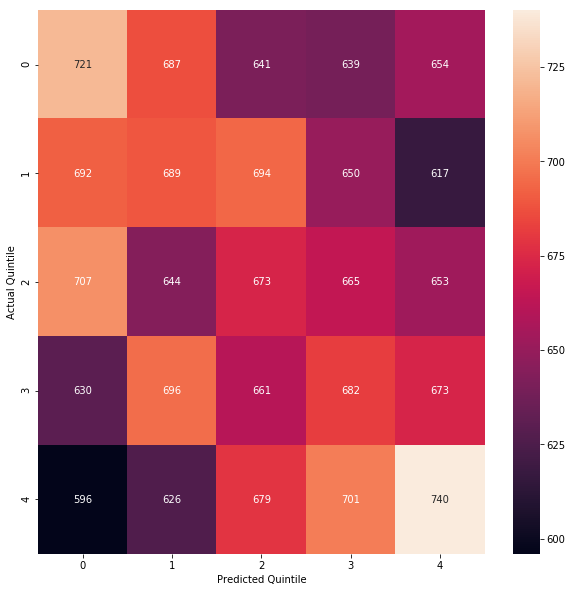

---
sklearn.linear_model.logistic.LogisticRegression
<class 'type'>
13:40:42 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  9
Food: long 201 times, short 109 times, total 310 times
Beer: long 176 times, short 143 times, total 319 times
Smoke: long 217 times, short 151 times, total 368 times
Games: long 170 times, short 189 times, total 359 times
Books: long 204 times, short 121 times, total 325 times
Hshld: long 201 times, short 157 times, total 358 times
Clths: long 208 times, short 165 times, total 373 times
Hlth: long 200 times, short 155 times, total 355 times
Chems: long 105 times, short 209 times, total 3

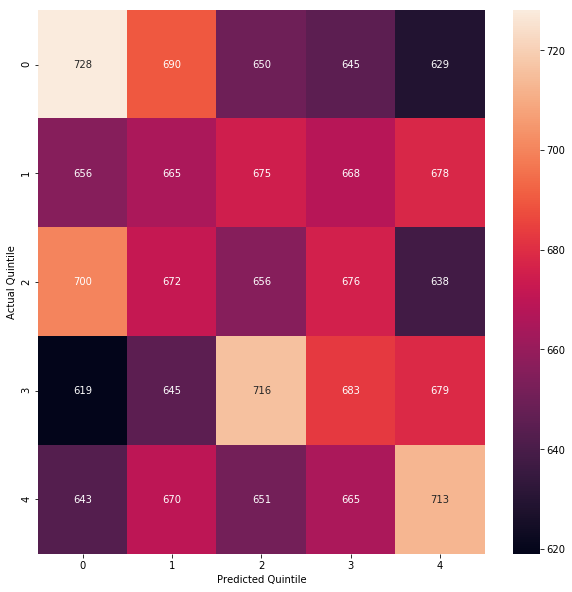

---
myMLPClassifier
<class 'function'>
13:40:45 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  7
Food: long 120 times, short 72 times, total 192 times
Beer: long 126 times, short 126 times, total 252 times
Smoke: long 206 times, short 140 times, total 346 times
Games: long 119 times, short 172 times, total 291 times
Books: long 156 times, short 106 times, total 262 times
Hshld: long 142 times, short 98 times, total 240 times
Clths: long 117 times, short 133 times, total 250 times
Hlth: long 137 times, short 106 times, total 243 times
Chems: long 85 times, short 150 times, total 235 times
Txtls: long 139 times, 

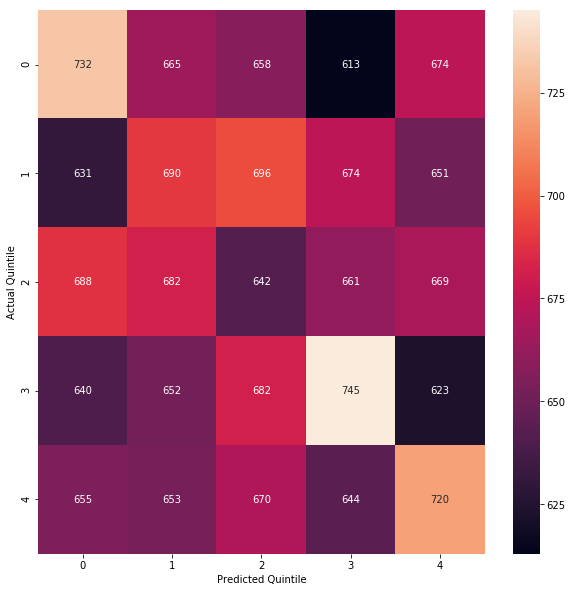

---
sklearn.ensemble.gradient_boosting.GradientBoostingClassifier
<class 'abc.ABCMeta'>
13:42:27 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  4
Food: long 82 times, short 46 times, total 128 times
Beer: long 65 times, short 59 times, total 124 times
Smoke: long 137 times, short 92 times, total 229 times
Games: long 94 times, short 98 times, total 192 times
Books: long 90 times, short 45 times, total 135 times
Hshld: long 65 times, short 61 times, total 126 times
Clths: long 58 times, short 81 times, total 139 times
Hlth: long 90 times, short 44 times, total 134 times
Chems: long 41 times, short 97 times, tota

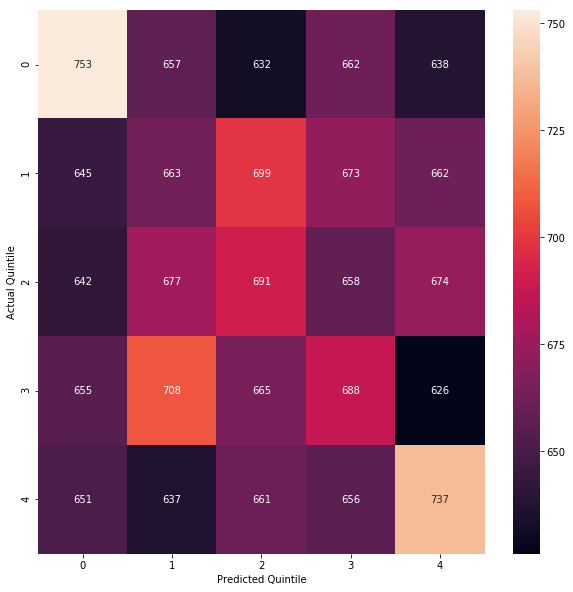

---
myXGBClassifier.<locals>.create_model
<class 'function'>
13:43:33 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  1
Food: long 0 times, short 70 times, total 70 times
Beer: long 55 times, short 1 times, total 56 times
Smoke: long 101 times, short 140 times, total 241 times
Games: long 1 times, short 20 times, total 21 times
Books: long 140 times, short 0 times, total 140 times
Hshld: long 0 times, short 0 times, total 0 times
Clths: long 0 times, short 36 times, total 36 times
Hlth: long 0 times, short 0 times, total 0 times
Chems: long 0 times, short 0 times, total 0 times
Txtls: long 0 times, short 0 times

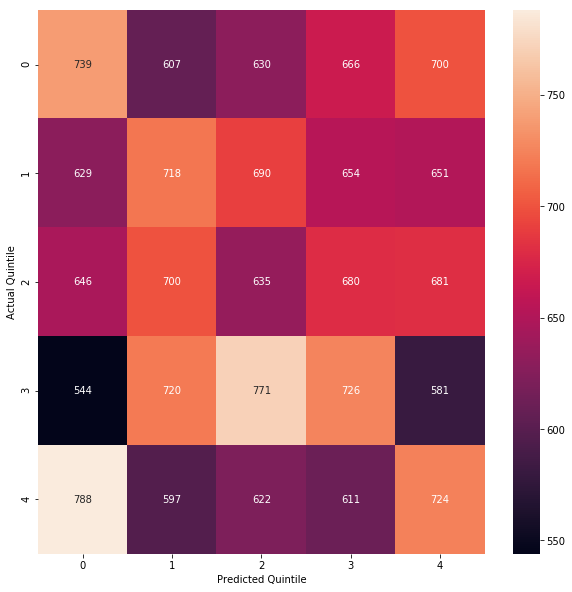

---
myLGBMClassifier.<locals>.create_model
<class 'function'>
13:43:47 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  9
Food: long 196 times, short 104 times, total 300 times
Beer: long 184 times, short 141 times, total 325 times
Smoke: long 255 times, short 168 times, total 423 times
Games: long 184 times, short 185 times, total 369 times
Books: long 177 times, short 149 times, total 326 times
Hshld: long 190 times, short 162 times, total 352 times
Clths: long 182 times, short 164 times, total 346 times
Hlth: long 206 times, short 128 times, total 334 times
Chems: long 100 times, short 200 times, total 300 tim

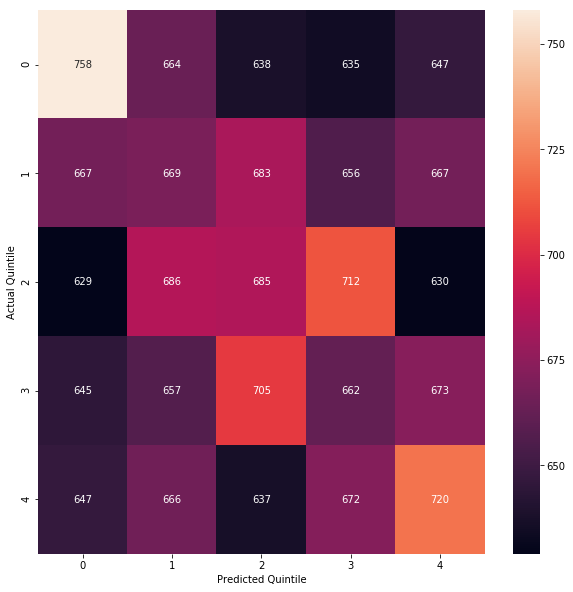

---
sklearn.ensemble.weight_boosting.AdaBoostClassifier
<class 'abc.ABCMeta'>
13:44:47 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  1
Food: long 38 times, short 41 times, total 79 times
Beer: long 19 times, short 11 times, total 30 times
Smoke: long 25 times, short 8 times, total 33 times
Games: long 7 times, short 12 times, total 19 times
Books: long 14 times, short 9 times, total 23 times
Hshld: long 33 times, short 9 times, total 42 times
Clths: long 27 times, short 15 times, total 42 times
Hlth: long 9 times, short 10 times, total 19 times
Chems: long 19 times, short 47 times, total 66 times
Txtls: long 3

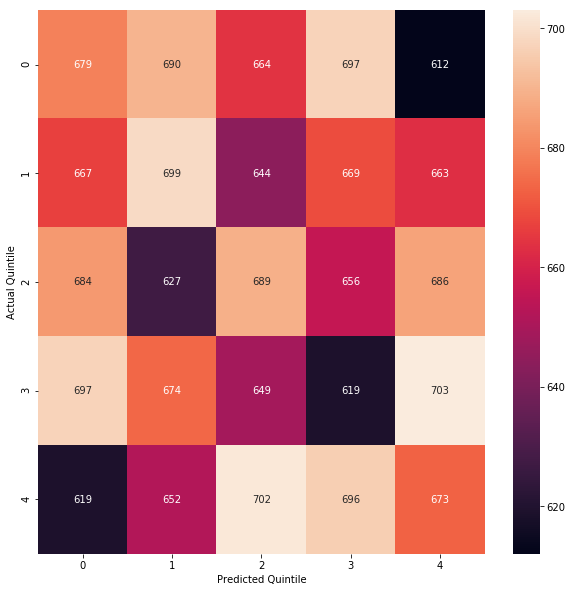

---
sklearn.ensemble.bagging.BaggingClassifier
<class 'abc.ABCMeta'>
13:45:03 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  11
Food: long 243 times, short 171 times, total 414 times
Beer: long 233 times, short 170 times, total 403 times
Smoke: long 242 times, short 194 times, total 436 times
Games: long 224 times, short 209 times, total 433 times
Books: long 244 times, short 160 times, total 404 times
Hshld: long 221 times, short 207 times, total 428 times
Clths: long 197 times, short 202 times, total 399 times
Hlth: long 227 times, short 163 times, total 390 times
Chems: long 129 times, short 270 times, total

.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  12
Food: long 275 times, short 170 times, total 445 times
Beer: long 246 times, short 204 times, total 450 times
Smoke: long 257 times, short 192 times, total 449 times
Games: long 224 times, short 235 times, total 459 times
Books: long 258 times, short 184 times, total 442 times
Hshld: long 238 times, short 212 times, total 450 times
Clths: long 229 times, short 214 times, total 443 times
Hlth: long 281 times, short 163 times, total 444 times
Chems: long 143 times, short 289 times, total 432 times
Txtls: long 269 times, short 173 times, total 442 times
Cnstr: long 189 times, short 244 times, total 433 times
Steel: long 130 times, short 323 times, total 453 times
FabPr: long 167 times, short 253 times, total 420 times
El

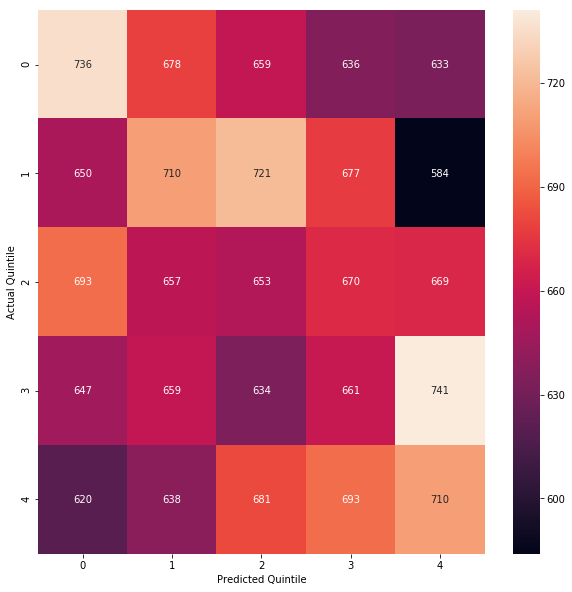

---
sklearn.naive_bayes.GaussianNB
<class 'abc.ABCMeta'>
13:45:20 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  13
Food: long 250 times, short 266 times, total 516 times
Beer: long 163 times, short 309 times, total 472 times
Smoke: long 277 times, short 244 times, total 521 times
Games: long 251 times, short 278 times, total 529 times
Books: long 352 times, short 165 times, total 517 times
Hshld: long 300 times, short 211 times, total 511 times
Clths: long 307 times, short 197 times, total 504 times
Hlth: long 213 times, short 312 times, total 525 times
Chems: long 179 times, short 325 times, total 504 times
T

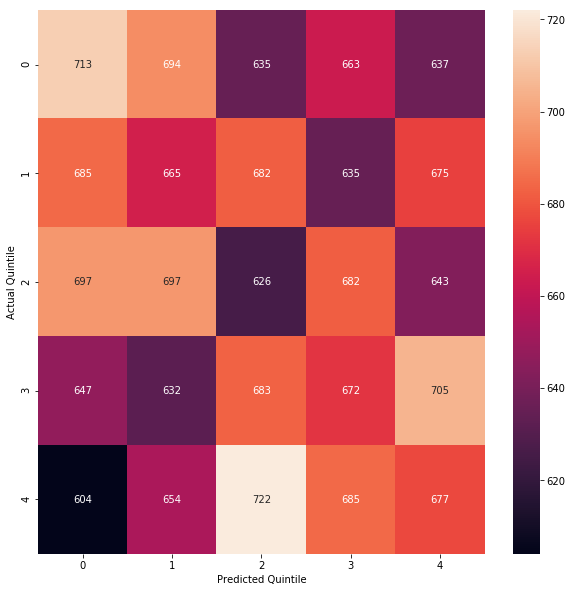

---
sklearn.gaussian_process.gpc.GaussianProcessClassifier
<class 'type'>
13:45:22 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  5
Food: long 0 times, short 556 times, total 556 times
Beer: long 556 times, short 0 times, total 556 times
Smoke: long 556 times, short 0 times, total 556 times
Games: long 556 times, short 0 times, total 556 times
Books: long 0 times, short 0 times, total 0 times
Hshld: long 0 times, short 0 times, total 0 times
Clths: long 0 times, short 0 times, total 0 times
Hlth: long 0 times, short 0 times, total 0 times
Chems: long 0 times, short 0 times, total 0 times
Txtls: long 0 times, sh

.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)
.
best return gen params:  15
Food: long 298 times, short 263 times, total 561 times
Beer: long 344 times, short 266 times, total 610 times
Smoke: long 295 times, short 248 times, total 543 times
Games: long 244 times, short 282 times, total 526 times
Books: long 326 times, short 267 times, total 593 times
Hshld: long 314 times, short 255 times, total 569 times
Clths: long 295 times, short 269 times, total 564 times
Hlth: long 301 times, short 214 times, total 515 times
Chems: long 269 times, short 261 times, total 530 times
Txtls: long 294 times, short 284 times, total 578 times
Cnstr: long 274 times, short 317 times, total 591 times
Steel: long 217 times, short 353 times, total 570 times
FabPr: long 274 times, short 269 times, total 543 times
El

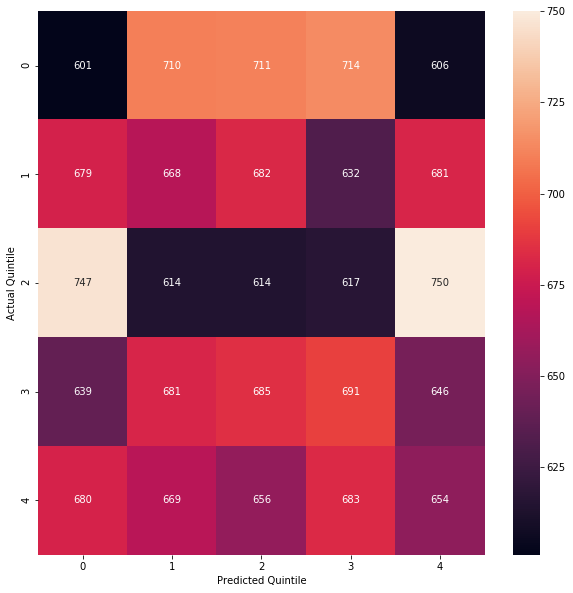

---
myVC.<locals>.create_model
<class 'function'>
13:46:48 Generate splits [140, 280, 419, 558, 697]
classify
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), putting predictions in rows range(140, 280)
.Training on first 280 rows (0:279), putting predictions in rows range(280, 419)
.Training on first 419 rows (0:418), putting predictions in rows range(419, 558)
.Training on first 558 rows (0:557), putting predictions in rows range(558, 697)


In [ ]:
est_names = []
sharpes = []
directional_accuracies=[]
in_sample_accuracies = []
cv_vals = []
for estimator in estimators:
    estname = str(estimator)[10:-19] if str(type(estimator))=="<class 'function'>" else str(estimator)[8:-2]
    print(estname)    
    est_names.append(estname)
    print( type(estimator))
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator, 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_four_classes)
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    _, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16), verbose=False)
    print("best return gen params: ", best_params)
    backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes.append(backtestmodel.sharpe)
    cv_vals.append(best_params)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies.append(backtestmodel.directional_accuracy)
        in_sample_accuracies.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies.append(np.nan)
        in_sample_accuracies.append(np.nan)
    
    print("---")
    

In [ ]:
# chart performance

def mychart(args, names=None, title=""):
    x_coords = np.linspace(1970, 2016, args[0].shape[0])
    plotdata = []
    for i in range(len(args)):
        tracelabel = "Trace %d" % i
        if names:
                tracelabel=names[i]
        plotdata.append(Scatter(x=x_coords,
                                y=args[i].values.reshape(-1),
                                mode = 'line',
                                name=tracelabel))    

    layout = Layout(
        title = title,
        autosize=False,
        width=900,
        height=600,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    


In [ ]:
def myscatter(arg1, arg2, names=None, title=""):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))

    layout = dict(
        title=title,
        autosize=False,
        width="600",
        height="480",
        yaxis=dict(
#            type='log',
            autorange=True
        )
    )
    
#    py.iplot(data, filename='basic-scatter')

    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)

In [ ]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['mse'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = dict(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

In [ ]:
myscatter(mse_list, sharpe_list, title="Sharpe vs. MSE")
myscatter(quintile_accuracy_list, sharpe_list, title="Sharpe vs. Quantile Accuracy")
myscatter(directional_accuracy_list, sharpe_list, title="Sharpe vs. Directional Accuracy")
myscatter(kendalltau_list, sharpe_list, title="Sharpe vs. Kendall's Tau")
myscatter(excess_tp_list, sharpe_list, title="Sharpe vs. True Positives")

In [ ]:
# 4-way plot for blog post
fig = plotly.tools.make_subplots(rows=2, cols=2, subplot_titles=('MSE', 'Quintile Accuracy','Direction Accuracy', "Kendall's tau"))
fig.append_trace(Scatter(
    x = mse_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=1)

fig.append_trace(Scatter(
    x = quintile_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=2)

fig.append_trace(Scatter(
    x = directional_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=1)

fig.append_trace(Scatter(
    x = kendalltau_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=2)


fig['layout'].update(height=1000, width=1000, title='Sharpe ratio scatters vs.')
iplot(fig)

In [ ]:
corrmatrix = skmetricsframe[['sharpe', 'mse',  'kendalltau', 
                           'quantile_score', 'direction_score', 'truepositive_score']].corr()
corrmatrix

In [ ]:
with open('sklearn_corr.html', 'w') as fo:
    corrmatrix.to_html(fo, float_format=lambda x: '%.3f' % x)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmatrix, annot=True, fmt='.3f')
plt.show()


In [ ]:
# tune XGBClassifier

keys = []
sharpes2 = []
directional_accuracies2=[]
in_sample_accuracies2 = []

n_estimators_list = [100, 300, 1000]
max_depth_list = [4]
learning_rate_list = [0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
subsample_list = [0.6, 0.7, 0.8]
hyperparameter_combos = list(product(n_estimators_list, max_depth_list, learning_rate_list, subsample_list))

def myXGBClassifier(n_estimators, max_depth, subsample, learning_rate):
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    n_estimators, max_depth, subsample, learning_rate = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_estimators, max_depth, subsample, learning_rate)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=myXGBClassifier(n_estimators,max_depth,subsample,learning_rate), 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_three_classes)
    backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes2.append(backtestmodel.sharpe)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies2.append(backtestmodel.directional_accuracy)
        in_sample_accuracies2.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies2.append(np.nan)
        in_sample_accuracies2.append(np.nan)

    print("---")

In [ ]:
metricsframe = pd.DataFrame(list(zip([k[0] for k in keys],
                                     [k[1] for k in keys],
                                     [k[2] for k in keys],
                                     [k[3] for k in keys],
                                     in_sample_accuracies2,
                                     directional_accuracies2,
                                     sharpes2)), 
                            columns = ['n_estimators', 'max_depth', 'learning_rate', 'subsample','in_sample_acc','oos_acc','sharpe'])
metricsframe
#do big dataframe,
#do summaries
#do heatmaps
# try catboost, lightgbm
#test my_categorical_entropy loss
#run keras with my_categorical entropy, see if you get better sharpes
#scale my_categorical_entropy loss vs. mse loss
#combine crossentropy and mse
#add fundamental data

In [ ]:
pd.DataFrame(metricsframe.groupby(['n_estimators'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['max_depth'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['subsample'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['learning_rate'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
model = catboost.CatBoostClassifier()

keys = []
sharpes3 = []
directional_accuracies3=[]
in_sample_accuracies3 = []

n_estimators_list = [1000]
max_depth_list = [4]
learning_rate_list = [0.001]
subsample_list = [0.7]
hyperparameter_combos = list(product(n_estimators_list, max_depth_list, learning_rate_list, subsample_list))

def myXGBClassifier(n_estimators=1000, max_depth=4, subsample=0.7, learning_rate=0.001):
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    n_estimators, max_depth, subsample, learning_rate = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_estimators, max_depth, subsample, learning_rate)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=myXGBClassifier(n_estimators,max_depth,subsample,learning_rate), 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_three_classes)
    backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes3.append(backtestmodel.sharpe)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies3.append(backtestmodel.directional_accuracy)
        in_sample_accuracies3.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies3.append(np.nan)
        in_sample_accuracies3.append(np.nan)

    print("---")

In [ ]:
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print(backtestmodel.directional_accuracy)
print(backtestmodel.insample_accuracy)
 

In [ ]:

class LightGbmWrapper:
    """Wrap Lightgbm model to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, 
                 param = {'num_leaves':31, 'num_trees':100, 'objective':'multiclass', 'num_class':3, 'metric': 'multi_logloss',},
                 num_round=10):
        self.param = param
        self.num_round = num_round
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            train_data = lgb.Dataset(X_fit, label=Y_fit[:,responsecol])
            model = lgb.train(self.param, train_data, self.num_round)
            self.models.append(model)

    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows,1)))
        return [np.hstack(predictions) for predictions in retlist]

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(np.array(Z), axis=0)
        
        

In [ ]:
Y_class = make_three_classes(Y)
Y_class[0]

In [ ]:
mw = LightGbmWrapper()
mw.fit(X,Y_class)
Z = mw.predict_proba(X[0].reshape(1,30))
print(len(Z))
print(Z[0].shape)
Z

In [ ]:
mw.predict(X[0].reshape(1,30))

In [ ]:
backtestmodel = BacktestModel(X, Y, 
                              model=LightGbmWrapper(), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_three_classes)
backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
backtestmodel.gen_returns(calc_returns, verbose=False)

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

### Perform cross-validation on Keras neural networks to select best architecture

In [ ]:
# use keras instead of sklearn MLPRegressor
# wrap keras model in a class 
# multioutput 30 predictions simultaneously to speed up 
# fit takes a list of response ys, predict returns a list of y_predict arrays
# no coef_dict

NCLASSES=3
INPUT_DIM = X.shape[1]
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 137
EPOCHS=1000
# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(NCLASSES, 
                                 activation='softmax',
                                 name = "Output%02d" % (i+1))(lastlayer))
            
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss='categorical_crossentropy', 
                           optimizer="rmsprop", 
                           metrics=['accuracy'])
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]

        if epochs:
            self.epochs = epochs
            
        fit = self.model.fit(X,
                             Y_list,
                             batch_size=BATCH_SIZE,
                             epochs=self.epochs,
                             verbose=verbose)
        
        self.history = fit.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return fit
        
    def predict_proba(self, X, verbose=False):
        nrows, npredictors = X.shape
        y_list = self.model.predict(X)
        nresponses = len(y_list)
        retarray = np.zeros([NCLASSES, nrows, OUTPUT_DIM])
        
        for response in range(OUTPUT_DIM):
            for row in range(nrows):
                for i in range(NCLASSES):
                    retarray[i, row, response] = y_list[response][row, i]
                
        return retarray

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(Z, axis=0)
      
    def evaluate(self, X, Y):
        """predict classes using X"""
        # convert list of ys to Y array
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]
        evaluate_array = self.model.evaluate(X, Y_list, batch_size=BATCH_SIZE, verbose=False)
        self.accuracy = np.mean(np.array(evaluate_array[-npredictors:]))
        
        return self.accuracy
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


In [ ]:
# no hidden layer, linear activation = LinearRegression
# confirm similar results to sklearn LinearRegression
keras_model = KerasBacktestModel(n_hidden_layers = 1,
                                 hidden_layer_size=16,
                                 reg_penalty = 3.0,
                                 verbose=True,
                                 epochs=500)
keras_model

In [ ]:
keras_model.fit(X,Y_class)
z = keras_model.predict_proba(X[:4])
print(z[1].shape)
z

In [ ]:
z = keras_model.predict(X[:4])
print(z[1].shape)
z

In [ ]:
backtestmodel = BacktestModel(X, Y, 
                              model=keras_model, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_three_classes)
backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
backtestmodel.gen_returns(calc_returns, verbose=False)

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

In [ ]:
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

In [ ]:
# same w/custom loss function

NCLASSES=3
INPUT_DIM = X.shape[1]
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 137
EPOCHS=1000
# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

# custom Keras loss function for ordinal regression

# apply weights on cross-entropy to penalize wronger answers by more
weights = tf.constant(np.array(np.matrix("""0.5, 0.5, 0.5; 0.5, 0.5, 3.5; 0.5, 3.5, 0.5""")),dtype=tf.float32)

def my_categorical_cross_entropy(target, output, from_logits=False, axis=-1):
    """Categorical crossentropy between an output tensor and a target tensor.
    # Arguments
        target: A tensor of the same shape as `output`.
        output: A tensor resulting from a softmax
            (unless `from_logits` is True, in which
            case `output` is expected to be the logits).
        from_logits: Boolean, whether `output` is the
            result of a softmax, or is a tensor of logits.
        axis: Int specifying the channels axis. `axis=-1`
            corresponds to data format `channels_last`,
            and `axis=1` corresponds to data format
            `channels_first`.
    # Returns
        Output tensor.
    # Raises
        ValueError: if `axis` is neither -1 nor one of
            the axes of `output`.
    """
    output /= tf.reduce_sum(output, axis, True)
    # manual computation of crossentropy
    _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    raw_loss = - tf.log(target * output + (1 - target) * (1 - output))
    weight_array = tf.matmul(target, weights)
    weighted_loss = weight_array * raw_loss
    
    return tf.reduce_sum(weighted_loss, axis)


class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(NCLASSES, 
                                 activation='softmax',
                                 name = "Output%02d" % (i+1))(lastlayer))
            
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss=my_categorical_cross_entropy, 
                           optimizer="rmsprop", 
                           metrics=['accuracy'])
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]

        if epochs:
            self.epochs = epochs
            
        fit = self.model.fit(X,
                             Y_list,
                             batch_size=BATCH_SIZE,
                             epochs=self.epochs,
                             verbose=verbose)
        
        self.history = fit.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return fit
        
    def predict_proba(self, X, verbose=False):
        nrows, npredictors = X.shape
        y_list = self.model.predict(X)
        nresponses = len(y_list)
        retarray = np.zeros([NCLASSES, nrows, OUTPUT_DIM])
        
        for response in range(OUTPUT_DIM):
            for row in range(nrows):
                for i in range(NCLASSES):
                    retarray[i, row, response] = y_list[response][row, i]
                
        return retarray

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(Z, axis=0)
      
    def evaluate(self, X, Y):
        """predict classes using X"""
        # convert list of ys to Y array
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]
        evaluate_array = self.model.evaluate(X, Y_list, batch_size=BATCH_SIZE, verbose=False)
        self.accuracy = np.mean(np.array(evaluate_array[-npredictors:]))
        
        return self.accuracy
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


In [ ]:
test_Y = tf.constant([1, 0, 0, 0, 1, 0, 0, 0, 1], shape=[3,3], name='test_Y', dtype=tf.float32)
test_Y_pred = tf.constant([0.7, 0.2, 0.1, 0.7, 0.2, 0.1, 0.7, 0.2, 0.1], shape=[3,3], name='test_Y_pred', dtype=tf.float32)
test_loss = keras.losses.categorical_crossentropy(test_Y, test_Y_pred)

weights = tf.constant(np.array(np.matrix("""0.5, 0.5, 0.5; 0.5, 0.5, 3.5; 0.5, 3.5, 0.5""")),dtype=tf.float32)
test_custom_loss = my_categorical_cross_entropy(test_Y, test_Y_pred)
#sess = tf.Session()
#.set_session(sess)
print (sess.run(test_Y))
print (sess.run(test_Y_pred))
print (sess.run(test_loss))
print (sess.run(test_custom_loss))

# this closes the session - should just open it and set it up top


In [ ]:
print(np.log(0.7))
print(np.log(0.2))
print(np.log(0.1))
print(np.log(0.7)+np.log(0.8)+np.log(0.9))

In [ ]:
# no hidden layer, linear activation = LinearRegression
# confirm similar results to sklearn LinearRegression
keras_model = KerasBacktestModel(n_hidden_layers = 1,
                                 hidden_layer_size=16,
                                 reg_penalty = 3.0,
                                 verbose=True,
                                 epochs=500)
keras_model

In [ ]:

Y_class = make_three_classes(Y)
keras_model.fit(X,Y_class)
z = keras_model.predict_proba(X[:4])
print(z[1].shape)


In [ ]:
z = keras_model.predict(X[:4])
print(z[1].shape)
z

In [ ]:
backtestmodel = BacktestModel(X, Y, 
                              model=keras_model, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_three_classes)
backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
backtestmodel.gen_returns(calc_returns, verbose=False)

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=False)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

In [ ]:
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

In [ ]:
backtestmodel.model.last_loss

In [ ]:
# custom loss function
# output classification and regression
# loss = sum

NCLASSES=3
INPUT_DIM = X.shape[1]
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 137
EPOCHS=1000
# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

# custom Keras loss function for ordinal regression

# apply weights on cross-entropy to penalize wronger answers by more
weights = tf.constant(np.array(np.matrix("""0.5, 0.5, 0.5; 0.5, 0.5, 3.5; 0.5, 3.5, 0.5""")),dtype=tf.float32)

def my_categorical_cross_entropy(target, output, from_logits=False, axis=-1):
    """Categorical crossentropy between an output tensor and a target tensor.
    # Arguments
        target: A tensor of the same shape as `output`.
        output: A tensor resulting from a softmax
            (unless `from_logits` is True, in which
            case `output` is expected to be the logits).
        from_logits: Boolean, whether `output` is the
            result of a softmax, or is a tensor of logits.
        axis: Int specifying the channels axis. `axis=-1`
            corresponds to data format `channels_last`,
            and `axis=1` corresponds to data format
            `channels_first`.
    # Returns
        Output tensor.
    # Raises
        ValueError: if `axis` is neither -1 nor one of
            the axes of `output`.
    """
    output /= tf.reduce_sum(output, axis, True)
    # manual computation of crossentropy
    _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    raw_loss = - tf.log(target * output + (1 - target) * (1 - output))
    weight_array = tf.matmul(target, weights)
    weighted_loss = weight_array * raw_loss
    
    return tf.reduce_sum(weighted_loss, axis)


class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(NCLASSES, 
                                 activation='softmax',
                                 name = "Output%02d" % (i+1))(lastlayer))
            
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss=my_categorical_cross_entropy, 
                           optimizer="rmsprop", 
                           metrics=['accuracy'])
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]

        if epochs:
            self.epochs = epochs
            
        fit = self.model.fit(X,
                             Y_list,
                             batch_size=BATCH_SIZE,
                             epochs=self.epochs,
                             verbose=verbose)
        
        self.history = fit.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return fit
        
    def predict_proba(self, X, verbose=False):
        nrows, npredictors = X.shape
        y_list = self.model.predict(X)
        nresponses = len(y_list)
        retarray = np.zeros([NCLASSES, nrows, OUTPUT_DIM])
        
        for response in range(OUTPUT_DIM):
            for row in range(nrows):
                for i in range(NCLASSES):
                    retarray[i, row, response] = y_list[response][row, i]
                
        return retarray

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(Z, axis=0)
      
    def evaluate(self, X, Y):
        """predict classes using X"""
        # convert list of ys to Y array
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]
        evaluate_array = self.model.evaluate(X, Y_list, batch_size=BATCH_SIZE, verbose=False)
        self.accuracy = np.mean(np.array(evaluate_array[-npredictors:]))
        
        return self.accuracy
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


In [ ]:
1. train 3 layers for regression
2. save model
3. load model
4. make hidden layers non-trainable
5. train for classification

load model
find hidden layers, make non-trainable
do a predictwrapper that loads the model, makes hidden non_trainable, adds my_categorical outputs, compiles a classification model

In [ ]:

class RegressionModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            # by rows
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # self.Xscale = scaler().fit_transform(self.Xscale.transpose()).transpose()
            # self.Yscale = scaler().fit_transform(self.Yscale.transpose()).transpose()
            # by cols
            # MinMaxScaler: each col (min->0, max->1) 
            # StandardScaler: each col (mean->0, SD->1)            
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.Yscale = scaler().fit_transform(self.Yscale)
        
        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=False)
            
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        

    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        self.mse = np.mean(msetemp)
        print("OOS MSE across all predictions: %.4f" % self.mse)
        self.model.fit(self.Xscale, self.Yscale)
        Y_pred = self.model.predict(self.Xscale)
        self.in_sample_mse = np.mean((Y_pred - self.Yscale) ** 2)
        print("In-sample MSE: %.4f" % self.in_sample_mse)

        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- self.mse/y_variance))
        
        return(self.mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        self.kendalltaus = []
        self.ktpvals = []
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))
            kt, p_val = kendalltau(self.P[row], self.Y[row])
            self.kendalltaus.append(kt)
            self.ktpvals.append(p_val)

        self.kendalltau = np.mean(self.kendalltaus)
        self.kendalltau_pvalue = np.mean(self.ktpvals)         
        print("Avg rank correlation (Kendall's tau): %.4f (Expected: 0)" % (self.kendalltau))
        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols)
        self.quintile_accuracy = accuracy_score(pred_quantiles, true_quantiles)
        print("5-quintile accuracy: %.4f (Expected: 0.2)" % (self.quintile_accuracy))
        
        pred_direction = np.zeros(nrows*ncols)
        true_direction = np.zeros(nrows*ncols)
        for i in range(nrows*ncols):
            if pred_quantiles[i] == 4:
                pred_direction[i] = 1
            elif pred_quantiles[i] == 0:
                pred_direction[i] = -1
            if true_quantiles[i] == 4:
                true_direction[i] = 1
            elif true_quantiles[i] == 0:
                true_direction[i] = -1
        self.directional_accuracy = accuracy_score(pred_direction, true_direction)
        print("Long/short/flat accuracy: %.4f (Expected: 0.44)" % (self.directional_accuracy))
        
        nrows = nrows * ncols
            
        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])*nrows

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat5 = confusion_matrix(temp_pred, temp_actual)
            diff_mat = conf_mat5 - conf_mat_expected
            if verbose:
                print("Confusion matrix for quantile %d" % q)
                print(conf_mat5)
                cstmp, cspvtmp = chisquare(conf_mat5.reshape(4), conf_mat_expected.reshape(4))
                print("Chi-square: %.4f (p-value: %.8f)" % (cstmp, cspvtmp))

            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = diff_mat[1][1]
            myscores.append(myscore)

        # sum of true positive for top and bottom quintiles
        self.excess_tp = myscores[0] + myscores[4]
        print("Excess true positive in quintiles 1 + 5: %f" % (self.excess_tp))

        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual Quintile')
            plt.xlabel('Predicted Quintile')
            plt.show()
        
        return None

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-folds
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        self.gen_predictions_classify(verbose=False, classindexes=[0,1,2,3])
        
        return self.gen_predictions(splits=last_indexes, verbose=verbose)
    
    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.ycols
        longcount = [0] * self.ycols
        shortcount = [0] * self.ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
        if verbose:
            for i in range(len(responses)):
                print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                             longcount[i], 
                                                                             shortcount[i], 
                                                                             indcount[i]))
        return self.R

    def report_returns(self, start_date='01/01/1970', freq='M'):

        first_pred_month=self.startindex        
        self.results = self.R[first_pred_month:]
        nmonths = self.results.shape[0]
        nyears = nmonths/12.0
        index = pd.date_range(start_date,periods=nmonths, freq=freq)
        perfdata = pd.DataFrame(self.results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + self.results / 100)
        self.cumulative_return = perfdata['Equity']
        self.mean_monthly_return_annualized = np.mean(1 + self.results/100) ** 12 - 1
        self.mean_return = (self.cumulative_return[-1]/100) ** (1.0/nyears) - 1
        self.annualized_vol = np.std(self.results/100) * np.sqrt(12.0)
        self.sharpe = self.mean_monthly_return_annualized/self.annualized_vol
        print("Mean return: %.3f%%" % (self.mean_return * 100 ))
        #print("Mean monthly annualized return: %.3f%%" % (self.mean_monthly_return_annualized * 100 ))
        #print("Monthly annualized volatility: %.3f%%" % (self.annualized_vol * 100))
        print("Monthly Sharpe ratio: %.3f" % (self.sharpe))

class KerasRegressionModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        self.main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=self.main_input
        
        self.hiddenlayers=[]
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Hidden%02d" % i)(lastlayer)
            self.hiddenlayers.append(lastlayer)
            
        self.outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            self.outputs.append(Dense(1,
                                 activation='linear',
                                 name='output%02d' % i)(lastlayer)
                          )
            
        self.model = Model(inputs=[self.main_input], outputs=self.outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss="mse", metrics=["mse"], optimizer="adam", loss_weights=[1.]*OUTPUT_DIM)
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        Y_list = [Y[:,i] for i in range(OUTPUT_DIM)]
        
        if epochs:
            self.epochs = epochs

        retval = self.model.fit(X,
                                Y_list,
                                batch_size=BATCH_SIZE,
                                epochs=self.epochs,
                                verbose=verbose)
        self.history = retval.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return retval
    
    
    def predict(self, X, verbose=False):
        y_list = self.model.predict(X)
        # convert list of ys to Y array
        npreds=len(y_list[0])
        Y_pred = [y.reshape(npreds) for y in y_list]
        Y_pred = np.array(Y_pred).transpose()    
        return Y_pred
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" %  modelname)
        
    def load_model(self, modelname):
        model = load_model('%s.h5' % modelname)
        model.load_weights("%s_weights.h5" % modelname)
        self.model = model
        print("Loaded model from disk")


In [ ]:
MODELPREFIX='NNREGRESSION'
# run selected model
def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasRegressionModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)
# run selected model
experiment_model = RegressionModel(X, Y, 
                                 create_keras_model(1,16,3.0),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)

experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)
experiment_model.model.save("%s_%d_%d_%.6f" % (MODELPREFIX, 1, 16, 3))


In [ ]:
mymodel = Model(inputs=[main_input.input], outputs=outputs)
mymodel.compile(loss='categorical_crossentropy', 
                optimizer="rmsprop", 
                metrics=['accuracy'])
xxx
experiment_model = RegressionModel(X, Y, 
                                 create_keras_model(1,16,3.0),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)

experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)


In [ ]:
def frozenmodel(modelname):
    def create_model():
        mymodel = create_keras_model(1,16,3.0)
        mymodel.load_model(modelname)
        
        # make hidden layer non-trainable
        hiddenlayer = mymodel.model.get_layer(name='Hidden00')
        hiddenlayer.trainable = False
        
        # add softmax outputs
        outputs=[]
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(NCLASSES, 
                                 activation='softmax',
                                 name = "Softmax%02d" % (i+1))(hiddenlayer.output))
        # make a new model     
        main_input=mymodel.model.get_layer(name='main_input')
        mymodel.model = Model(inputs=[main_input.input], outputs=outputs)
        mymodel.model.compile(loss='categorical_crossentropy', 
                              optimizer="rmsprop", 
                              metrics=['accuracy'])
        return mymodel
    
    return create_model

backtestmodel = BacktestModel(X, Y, 
                              model=frozenmodel("NNREGRESSION_116_3.000000")(), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_three_classes)

In [ ]:
backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
backtestmodel.gen_returns(calc_returns, verbose=False)

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

In [ ]:
# perform cross-validation on many Keras NN models
MODELPREFIX = "NN"


n_hiddens = [1, 2, 3]
layer_sizes = [1, 2, 4, 8, 16]
reg_penalties = [0.0, 0.1, 0.3, 1, 3, 10, 30, 100]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
# should really just use a list and convert to dataframe
keys = []
mses = []
sharpes = []
quantile_scores = []
kendalltaus = []
excess_true_positives = []
directional_accuracies = []

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, layer_size, reg_penalty)
    print("%s n_hidden_layers = %d, hidden_layer_size = %d, reg_penalty = %.6f" % 
          (time.strftime("%H:%M:%S"), n_hidden_layers, layer_size, reg_penalty))
    
    experiment_model = BacktestModel(X, Y, 
                                     create_keras_model(n_hidden_layers,layer_size,reg_penalty), 
                                     coef_dict_param="all", 
                                     startindex=FIRST_TRAIN_MONTHS,
                                     fit_missing='mean',
                                     scaler=None)
    experiment_model.walkforward_xval(n_splits=5)
    experiment_model.model.save("%s_%d_%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
    experiment_model.gen_returns(calc_returns, verbose=False)
    experiment_model.report_returns(start_date=start_date_str, freq='M')
    experiment_model.evaluate_predictions()
    experiment_model.evaluate_quantiles(chart=False, verbose=False)
    print("---")
    keys.append(key)
    mses.append(experiment_model.mse)
    quantile_scores.append(experiment_model.quintile_accuracy)
    directional_accuracies.append(experiment_model.directional_accuracy)
    kendalltaus.append(experiment_model.kendalltau)
    excess_true_positives.append(experiment_model.excess_tp)
    sharpes.append(experiment_model.sharpe)



In [ ]:
# review metrics - not very good
flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(keys, mses, sharpes, 
                                                                              quantile_scores, directional_accuracies, kendalltaus, excess_true_positives):
    flatlist.append([key[0], key[1], key[2], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
    
metricsframe = pd.DataFrame(flatlist, columns = ['layers', 'layer_size', 'reg_penalty',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

metricsframe.to_csv("KerasNeuralNetMetrics.csv")
#metricsframe.sort_values(['kendalltau'], ascending=False)[['alpha','l1_ratio']].values[:12]

In [ ]:
metricsframe = pd.read_csv("KerasNeuralNetMetrics.csv")[['layers','layer_size','reg_penalty','mse','sharpe','quantile_score','direction_score','kendalltau','truepositive_score']]
metricsframe

In [ ]:
with open('nn_by_mse.html', 'w') as fo:
    metricsframe.sort_values(['mse'], ascending=True).iloc[:8,:].to_html(fo, float_format=lambda x: '%.3f' % x)
    
with open('nn_by_sharpe.html', 'w') as fo:
    metricsframe.sort_values(['sharpe'], ascending=False).iloc[:8,:].to_html(fo, float_format=lambda x: '%.3f' % x)    

In [ ]:
plot_matrix(metricsframe, "layers", "layer_size", x_suffix=" layers", y_suffix=" units")
plot_matrix(metricsframe, "layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")
plot_matrix(metricsframe, "reg_penalty", "layer_size", x_suffix=" p", y_suffix="units")

In [ ]:
pd.DataFrame(metricsframe.groupby(['layers'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['layer_size'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['reg_penalty'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [ ]:
myscatter(mses, sharpes, title="Sharpe vs. MSE")
myscatter(quantile_scores, sharpes, title="Sharpe vs. Quantile Accuracy")
myscatter(directional_accuracies, sharpes, title="Sharpe vs. Directional Accuracy")
myscatter(kendalltaus, sharpes, title="Sharpe vs. Kendall's Tau")
myscatter(excess_true_positives, sharpes, title="Sharpe vs. True Positives")


In [ ]:
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(1,16,3.0),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d_%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)


In [ ]:
# backtest 2, 16, 0.3 with walk-forward MSE of 116.058 and walk-forward Sharpe of 0.779
# full backtest Sharpe is 0.157

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(2,16,0.3),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d_%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)

#Mean return: 0.835%
#Monthly Sharpe ratio: 0.157
#OOS MSE across all predictions: 125.1283
#In-sample MSE: 14.3808
#Variance: 39.4097
#R-squared: -2.1751
#Avg rank correlation (Kendall's tau): 0.0159 (Expected: 0)
#5-quintile accuracy: 0.2184 (Expected: 0.2)
#Long/short/flat accuracy: 0.4707 (Expected: 0.44)
#Excess true positive in quintiles 1 + 5: 207.800000

In [ ]:
# backtest 1, 16, 30 with walk-forward MSE of 40.933 and walk-forward Sharpe of 0.411

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(1,16,30),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d_%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)

